In [1238]:
import os
import yfinance as yf
import quantstats as qs
import scipy.cluster.hierarchy as sch
import cvxopt as opt
import matplotlib.pyplot as plt
import shutil
import base64
import talib
import cvxpy as cp

from fredapi import Fred
from scipy.stats import spearmanr
from io import BytesIO
from datetime import timedelta
from IPython.display import Image
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
from cvxopt import blas, solvers
from IPython.display import display
from scipy.optimize import minimize
from matplotlib.backends.backend_svg import FigureCanvasSVG

from prep_factor import PrepFactor
from functions.utils.system import *
from functions.utils.func import *

import warnings

warnings.filterwarnings('ignore')

|

# Params

In [1316]:
# Params
live = True
start = '2005-01-01'
current_date = date.today().strftime('%Y-%m-%d')
window = 126
threshold = 2_000_000_000
stock = read_stock(get_large_dir(live) / 'permno_live.csv')

|

In [1240]:
# Read in Data
price = pd.read_parquet(get_parquet_dir(live) / 'data_price.parquet.brotli')
fund_q = pd.read_parquet(get_parquet_dir(live) / 'data_fund_raw_q.parquet.brotli')
rf = pd.read_parquet(get_parquet_dir(live) / 'data_rf.parquet.brotli')
ret_price = create_return(price, [1])

# Resample to daily
date_index = price.drop(price.columns, axis=1)
fund_q = fund_q.groupby('permno').shift(3)
fund_q = date_index.merge(fund_q, left_index=True, right_index=True, how='left').groupby('permno').ffill()

\

In [1241]:
mom_season_short = PrepFactor(live=live, factor_name='factor_mom_season_short', group='permno', interval='D', kind='mom', stock=stock, div=False, start=start, end=current_date, save=False).prep()
mom_season6 = PrepFactor(live=live, factor_name='factor_mom_season6', group='permno', interval='D', kind='mom', stock=stock, div=False, start=start, end=current_date, save=False).prep()
mom_off_season = PrepFactor(live=live, factor_name='factor_mom_off_season', group='permno', interval='D', kind='mom', stock=stock, div=False, start=start, end=current_date, save=False).prep()
ind_mom = PrepFactor(live=live, factor_name='factor_ind_mom', group='permno', interval='D', kind='loading', stock=stock, div=False, start=start, end=current_date, save=False).prep()
lag_ret = PrepFactor(live=live, factor_name='factor_ret', group='permno', interval='D', kind='loading', stock=stock, div=False, start=start, end=current_date, save=False).prep()
volume = PrepFactor(live=live, factor_name='factor_volume', group='permno', interval='D', kind='loading', stock=stock, div=False, start=start, end=current_date, save=False).prep()

Creating factor_mom_season_short --------------------------- | ✔
Shape: (3104852, 1)
Creating factor_mom_season6 -------------------------------- | ✔
Shape: (3104852, 1)
Creating factor_mom_off_season ----------------------------- | ✔
Shape: (3104852, 1)
Creating factor_ind_mom ------------------------------------ | ✔
Shape: (3104852, 5)
Creating factor_ret ---------------------------------------- | ✔
Shape: (3104852, 5)
Creating factor_volume ------------------------------------- | ✔
Shape: (3104852, 5)
|

In [1242]:
lag_ret = lag_ret[['RET_21', 'RET_126']]
volume = volume[['VOL_21', 'VOL_126']]
ind_mom = ind_mom[['ind_mom_21', 'ind_mom_126']]

|

# Hedge Portfolio

In [817]:
# Get return data
def get_ret(ticker_list):
    data = get_data_fmp(ticker_list=ticker_list, start=start, current_date=current_date)
    data = data[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
    data = data.rename(columns={'Adj Close': 'Close'})
    data = create_return(data, [1])
    data = data.drop(['Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
    data = data.loc[~data.index.duplicated(keep='first')]
    data = data.fillna(0)
    return data

In [818]:
# Get commodity, real estate, bonds, and metal data
com_ticker = ['NEM', 'GOLD', 'FNV', 'WPM', 'AEM', 'XOM', 'CVX', 'SLB', 'COP', 'STLD', 'AMT', 'CCI', 'PLD', 
              'CTVA', 'SPG', 'EQIX', 'BND', 'AGG', 'BNDX', 'VCIT', 'MUB', 'VCSH', 'BSV', 'VTEB', 'IEF', 'MBB', 
              'GOVT', 'VGSH', 'TIP']
com_port = get_ret(com_ticker)

Fetching data:   0%|                                                                                                                                                                   | 0/29 [00:00<?, ?ticker/s]

/

Fetching data:   3%|█████▎                                                                                                                                                     | 1/29 [00:01<00:28,  1.01s/ticker]

/

Fetching data:   7%|██████████▋                                                                                                                                                | 2/29 [00:01<00:24,  1.10ticker/s]

-

Fetching data:  10%|████████████████                                                                                                                                           | 3/29 [00:03<00:35,  1.35s/ticker]

\

Fetching data:  14%|█████████████████████▍                                                                                                                                     | 4/29 [00:04<00:31,  1.24s/ticker]

\

Fetching data:  17%|██████████████████████████▋                                                                                                                                | 5/29 [00:05<00:26,  1.10s/ticker]

\

Fetching data:  21%|████████████████████████████████                                                                                                                           | 6/29 [00:06<00:23,  1.01s/ticker]

-

Fetching data:  24%|█████████████████████████████████████▍                                                                                                                     | 7/29 [00:07<00:24,  1.13s/ticker]

\

Fetching data:  28%|██████████████████████████████████████████▊                                                                                                                | 8/29 [00:08<00:22,  1.09s/ticker]

\

Fetching data:  31%|████████████████████████████████████████████████                                                                                                           | 9/29 [00:09<00:20,  1.05s/ticker]

\

Fetching data:  34%|█████████████████████████████████████████████████████                                                                                                     | 10/29 [00:10<00:18,  1.01ticker/s]

|

Fetching data:  38%|██████████████████████████████████████████████████████████▍                                                                                               | 11/29 [00:11<00:17,  1.04ticker/s]

|

Fetching data:  41%|███████████████████████████████████████████████████████████████▋                                                                                          | 12/29 [00:12<00:15,  1.08ticker/s]

|

Fetching data:  45%|█████████████████████████████████████████████████████████████████████                                                                                     | 13/29 [00:13<00:14,  1.10ticker/s]

\

Fetching data:  48%|██████████████████████████████████████████████████████████████████████████▎                                                                               | 14/29 [00:13<00:12,  1.23ticker/s]

\

Fetching data:  52%|███████████████████████████████████████████████████████████████████████████████▋                                                                          | 15/29 [00:14<00:11,  1.20ticker/s]

\

Fetching data:  55%|████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 16/29 [00:15<00:10,  1.19ticker/s]

\

Fetching data:  59%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 17/29 [00:16<00:09,  1.22ticker/s]

|

Fetching data:  62%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 18/29 [00:17<00:09,  1.18ticker/s]

\

Fetching data:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 19/29 [00:18<00:08,  1.23ticker/s]

\

Fetching data:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 20/29 [00:18<00:07,  1.26ticker/s]

\

Fetching data:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 21/29 [00:19<00:06,  1.23ticker/s]

\

Fetching data:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 22/29 [00:20<00:05,  1.26ticker/s]

\

Fetching data:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 23/29 [00:21<00:04,  1.21ticker/s]

\

Fetching data:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 24/29 [00:22<00:03,  1.27ticker/s]

\

Fetching data:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 25/29 [00:22<00:03,  1.23ticker/s]

\

Fetching data:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 26/29 [00:23<00:02,  1.23ticker/s]

\

Fetching data:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 27/29 [00:24<00:01,  1.25ticker/s]

-

Fetching data:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 28/29 [00:25<00:00,  1.28ticker/s]

-

Fetching data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:26<00:00,  1.11ticker/s]

\

In [819]:
com_port['vol'] = com_port.groupby('ticker')['RET_01'].rolling(60).std().reset_index(level=0, drop=True)
com_port['inv_vol'] = 1 / com_port['vol']
com_port['norm_inv_vol'] = com_port.groupby('date')['inv_vol'].apply(lambda x: x / x.sum()).reset_index(level=0, drop=True)
com_port['weighted_ret'] = com_port['RET_01'] * com_port['norm_inv_vol']
com_port = com_port.groupby('date')['weighted_ret'].sum()
com_port = com_port.to_frame()
com_port.columns = ['comm_ret']

/

### Macro

In [1195]:
fred = Fred(api_key='00e07a5c98e913ea393c3b1f089e21d1')
interest = fred.get_series("REAINTRATREARAT1YE").to_frame()
interest.columns = ['RIR']
interest = interest.shift(1)
date = com_port.index
date = date.to_frame().drop('date', axis=1).reset_index()
interest = interest.reset_index()
interest = pd.merge_asof(date, interest, left_on='date', right_on='index', direction='backward')
interest = interest.set_index('date').drop('index', axis=1)
interest = interest.ffill()

/

In [1196]:
fred = Fred(api_key='00e07a5c98e913ea393c3b1f089e21d1')
cpi = fred.get_series("CORESTICKM159SFRBATL").to_frame()
cpi.columns = ['CPI']
cpi = cpi.shift(1)
date = com_port.index
date = date.to_frame().drop('date', axis=1).reset_index()
cpi = cpi.reset_index()
cpi = pd.merge_asof(date, cpi, left_on='date', right_on='index', direction='backward')
cpi = cpi.set_index('date').drop('index', axis=1)
cpi = cpi.ffill()

|

In [1197]:
fred = Fred(api_key='00e07a5c98e913ea393c3b1f089e21d1')
yield_curve = fred.get_series("T10Y2Y").to_frame()
yield_curve.columns = ['YIELD']
yield_curve = yield_curve.shift(1)
date = com_port.index
date = date.to_frame().drop('date', axis=1).reset_index()
yield_curve = yield_curve.reset_index()
yield_curve = pd.merge_asof(date, yield_curve, left_on='date', right_on='index', direction='backward')
yield_curve = yield_curve.set_index('date').drop('index', axis=1)
yield_curve = yield_curve.ffill()

\

In [1198]:
macro = pd.concat([interest, cpi, yield_curve], axis=1)

In [1199]:
macro['RIR_z'] = (macro['RIR'] - macro['RIR'].mean()) / macro['RIR'].std()
macro['CPI_z'] = (macro['CPI'] - macro['CPI'].mean()) / macro['CPI'].std()
macro['YIELD_z'] = (macro['YIELD'] - macro['YIELD'].mean()) / macro['YIELD'].std()
macro['mt'] = macro[['RIR_z', 'CPI_z', 'YIELD_z']].mean(axis=1)

In [1200]:
T = [21, 60]
for t in T:
    macro[f'mt_{t}'] = macro['mt'].rolling(t).mean()

In [1201]:
# Macro
macro_buy = (macro['mt_21'] > macro['mt_60'])
macro_buy_df = macro_buy.to_frame('macro_buy')

In [1202]:
def calc_macro_port(row, col1, col2):
    if row['macro_buy']:
        return 0.50 * row[col1] + 0.50 * row[col2]
    else:
        return 0.25 * row[col1] + 0.75 * row[col2]

# Get Factor Betas

In [1317]:
ret = 'RET_01'
factor_data = (mom_season_short.merge(mom_season6, left_index=True, right_index=True, how='left')
               .merge(ind_mom, left_index=True, right_index=True, how='left')
               .merge(lag_ret, left_index=True, right_index=True, how='left')
               .merge(volume, left_index=True, right_index=True, how='left'))

factor_col= factor_data.columns.tolist()
combine = ret_price.merge(factor_data, left_index=True, right_index=True, how='left')

/

In [1318]:
def rolling_ols_mom(data, ret, factor_data, factor_cols, window, name):
    def process_stock(stock_data, ret, factor_data, factor_cols, window, stock_name, index_name):
        model_data = stock_data[[ret] + factor_cols]

        exog = sm.add_constant(model_data[factor_cols])

        rolling_ols = RollingOLS(endog=model_data[ret], exog=exog, window=window)
        factor_model_params = rolling_ols.fit(params_only=True).params.rename(columns={'const': 'ALPHA'})

        # Calculate predicted values
        predicted = (exog * factor_model_params).sum(axis=1)
        predicted = predicted.rename('pred')

        # Compute residuals (epsilon)
        epsilon = model_data[ret] - predicted
        epsilon = epsilon.rename('epsil')

        result = factor_model_params.assign(epsil=epsilon, pred=predicted)
        result = result.assign(**{index_name: stock_name}).set_index(index_name, append=True).swaplevel()
        return result

    tasks = [(group, ret, factor_data, factor_cols, window, stock, data.index.names[0]) for stock, group in data.groupby(data.index.names[0])]
    results = Parallel(n_jobs=-1)(delayed(process_stock)(*task) for task in tasks)

    return pd.concat(results).rename(columns=lambda x: f'{x}_{name}_{window:02}')

-

In [1319]:
# Execute Rolling LR
beta_data = rolling_ols_mom(data=combine, ret=ret, factor_data=factor_data, factor_cols=factor_col, window=window, name=f'mom_01')

\

# Get Sector Betas

In [1333]:
# Read in ETF data from FMP
etf_list = ['QQQ', 'XLE', 'XLV', 'VNQ', 'XLB', 'XLF', 'XLY', 'XLI', 'XLI', 'XLU', 'XLP']
T = [1]
sector_ret_past = get_data_fmp(ticker_list=etf_list, start=start, current_date=current_date)
sector_ret_past = sector_ret_past[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
sector_ret_past = sector_ret_past.rename(columns={'Adj Close': 'Close'})
sector_ret_past = sector_ret_past.loc[~sector_ret_past.index.duplicated(keep='first')]
# Create returns and unstack dataframe to only have 'date' index and 'ETF ticker' columns
sector_ret_past = create_return(sector_ret_past, T)
sector_ret_past = sector_ret_past.drop(['Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
sector_ret_past = sector_ret_past.unstack('ticker').swaplevel(axis=1)
sector_ret_past.columns = ['_'.join(col).strip() for col in sector_ret_past.columns.values]
sector_ret_past = sector_ret_past.fillna(0)

|

Fetching data:   0%|                                                                                                                                                                   | 0/11 [00:00<?, ?ticker/s]

/

Fetching data:   9%|██████████████                                                                                                                                             | 1/11 [00:01<00:12,  1.22s/ticker]

/

Fetching data:  18%|████████████████████████████▏                                                                                                                              | 2/11 [00:02<00:12,  1.40s/ticker]

-

Fetching data:  27%|██████████████████████████████████████████▎                                                                                                                | 3/11 [00:03<00:10,  1.28s/ticker]

\

Fetching data:  36%|████████████████████████████████████████████████████████▎                                                                                                  | 4/11 [00:05<00:10,  1.45s/ticker]

\

Fetching data:  45%|██████████████████████████████████████████████████████████████████████▍                                                                                    | 5/11 [00:06<00:07,  1.29s/ticker]

/

Fetching data:  55%|████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 6/11 [00:07<00:06,  1.22s/ticker]

/

Fetching data:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 7/11 [00:08<00:04,  1.12s/ticker]

\

Fetching data:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 8/11 [00:09<00:03,  1.12s/ticker]

\

Fetching data:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 9/11 [00:10<00:02,  1.06s/ticker]

|

Fetching data:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 10/11 [00:11<00:01,  1.05s/ticker]

\

Fetching data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:13<00:00,  1.19s/ticker]


-

In [1334]:
# Read in price data and set up params for Rolling LR
T = [1]
ret = f'RET_01'
past_data = pd.read_parquet(get_parquet_dir(live) / 'data_price.parquet.brotli')
factor_col_past = sector_ret_past.columns
past_data = create_return(past_data, T)
past_data = past_data.fillna(0)

/

In [1335]:
# Execute Rolling LR
beta_sector = rolling_ols_parallel(data=past_data, ret=ret, factor_data=sector_ret_past, factor_cols=factor_col_past.tolist(), window=window, name=f'sector_01')

\

In [1337]:
# Retrieve Needed Data
beta_sector = beta_sector[beta_sector.columns[1:14]]
beta_sector = beta_sector.fillna(0)

\

# Strategy

In [1320]:
betas = beta_data[beta_data.columns[1:len(factor_col)+2]].reset_index(level=0, drop=True)

|

In [1339]:
betas = beta_sector

/

<AxesSubplot:xlabel='permno,date'>

|

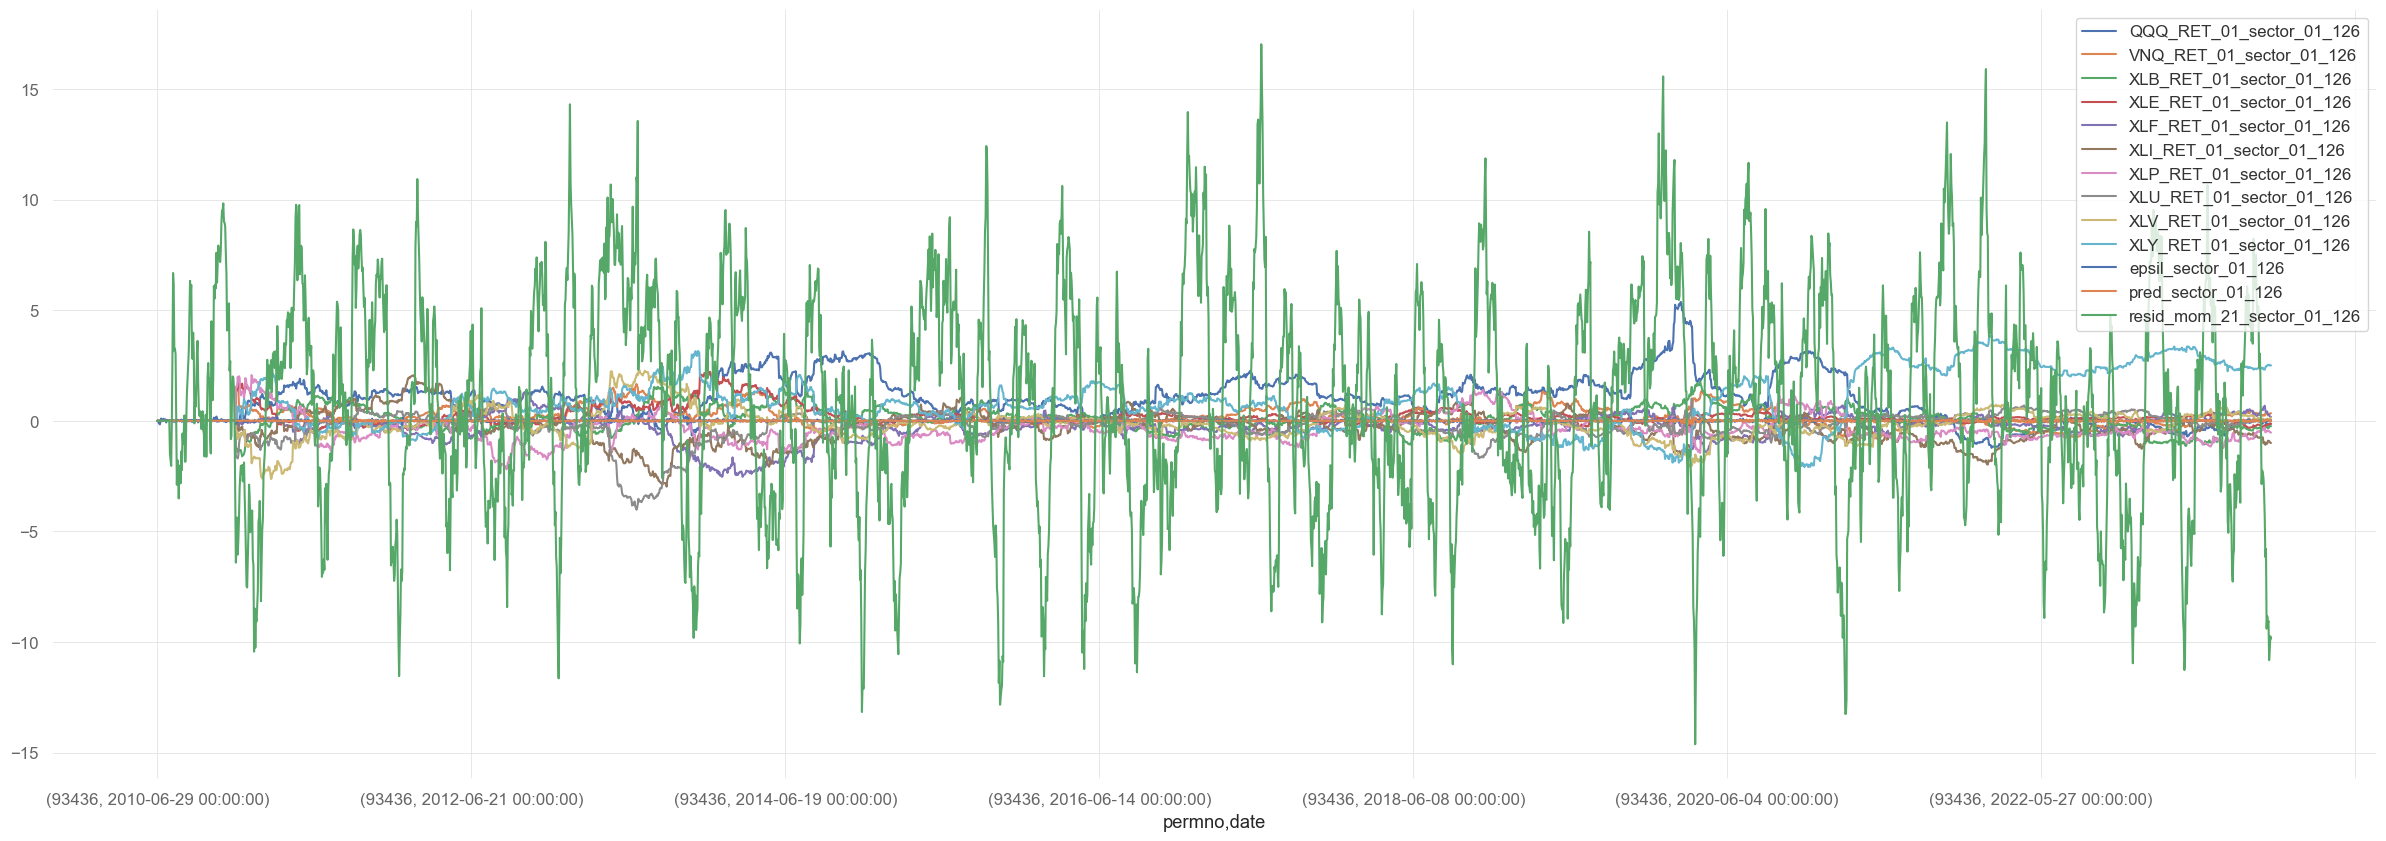

-

In [1340]:
tsla = get_stock_data(betas, 93436)
tsla.plot(figsize=(30,10))

In [1341]:
# Calculate rolling mean and standard deviation
rolling_mean = betas.groupby('permno')[f'epsil_sector_01_{window:02}'].rolling(window=window).mean().reset_index(level=0, drop=True)
rolling_std = betas.groupby('permno')[f'epsil_sector_01_{window:02}'].rolling(window=window).std().reset_index(level=0, drop=True)
# Calculate the rolling Z-score
betas['s_score'] = (betas[f'epsil_sector_01_{window:02}'] - rolling_mean) / rolling_std
betas = betas.rename(columns={f'epsil_sector_01_{window:02}': 'epsil'})



In [1342]:
market_cap = pd.read_parquet(get_parquet_dir(live) / 'data_misc.parquet.brotli', columns=['market_cap'])
betas_ret = combine.merge(betas, left_index=True, right_index=True, how='left')
betas_ret = betas_ret.merge(market_cap, left_index=True, right_index=True, how='left')

-

In [1343]:
betas_ret = betas_ret.loc[betas_ret.market_cap > threshold]

\

#### TA

In [1344]:
T = [5, 21, 60, 126, 252]
for t in T:
    betas_ret[f'ema_{t}'] = (betas_ret.groupby('permno', group_keys=False).apply(lambda x: talib.EMA(x.Close, timeperiod=t)))

for t in T:
    betas_ret[f'rsi_{t}'] = (betas_ret.groupby('permno', group_keys=False).apply(lambda x: talib.RSI(x.Close, timeperiod=t)))

for t in T:
    betas_ret[f'mfi_{t}'] = (betas_ret.groupby('permno', group_keys=False)
                             .apply(lambda x: talib.MFI(x.High, x.Low, x.Close, x.Volume, timeperiod=t)))
for t in T:
    betas_ret[f'cci_{t}'] = (betas_ret.groupby('permno', group_keys=False)
                             .apply(lambda x: talib.CCI(x.High, x.Low, x.Close, timeperiod=t)))

-

#### CUSUM

In [1351]:
betas_ret['CUSUM+'] = 0.0
betas_ret['CUSUM-'] = 0.0
betas_ret['epsil_30'] = betas_ret.groupby('permno')['epsil'].rolling(30).mean().reset_index(level=0, drop=True)
k = 0.001
h = 1

def calculate_cusum(group):
    cumsum = group['epsil_30'].cumsum()
    range_series = pd.Series(range(len(group)), index=group.index)
    group['CUSUM+'] = (cumsum - k * range_series).clip(lower=0)
    group['CUSUM-'] = (cumsum + k * range_series).clip(upper=0)
    return group

betas_ret = betas_ret.groupby('permno').apply(calculate_cusum).reset_index(level=0, drop=True)

/

<AxesSubplot:xlabel='permno,date'>

-

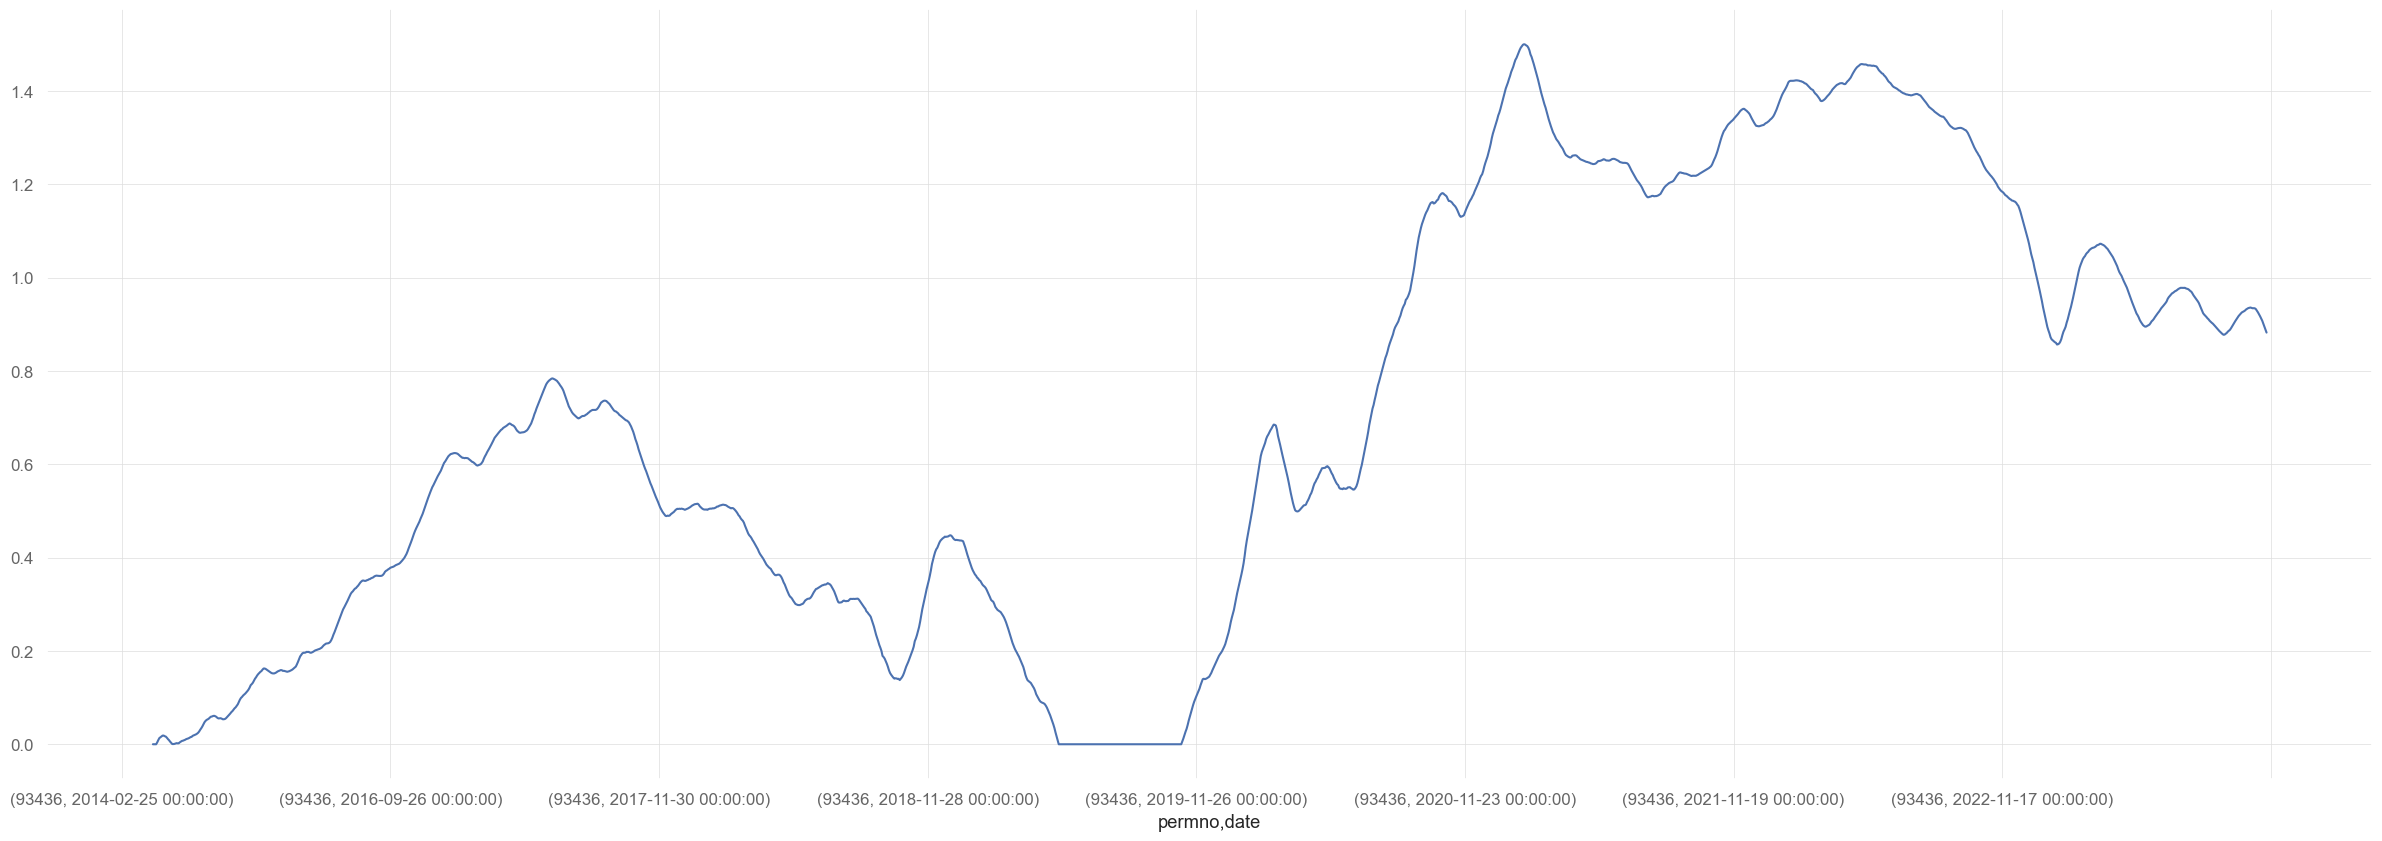

\

In [1352]:
tsla = get_stock_data(betas_ret, 93436)
tsla['CUSUM+'].plot(figsize=(30, 10))

<AxesSubplot:xlabel='permno,date'>

/

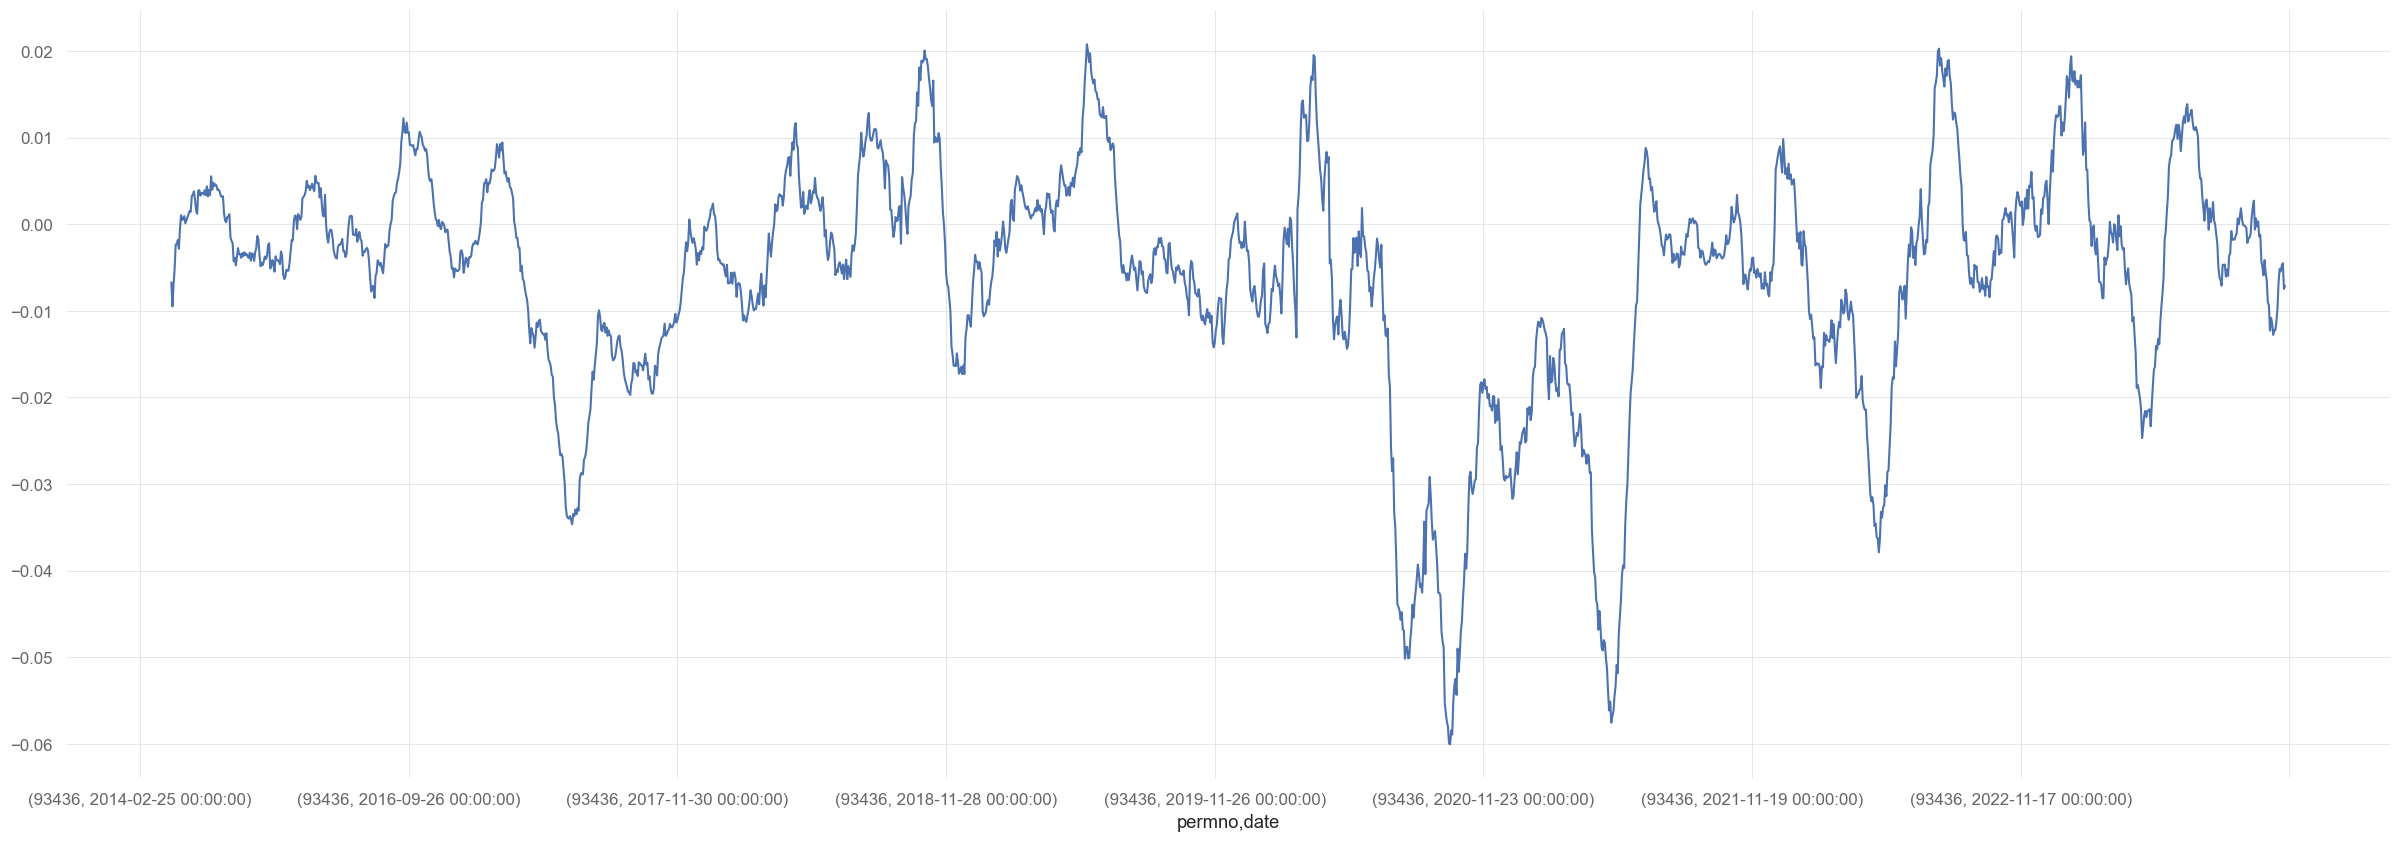

|

In [1331]:
tsla['epsil_30'].plot(figsize=(30, 10))

<AxesSubplot:xlabel='permno,date'>

\

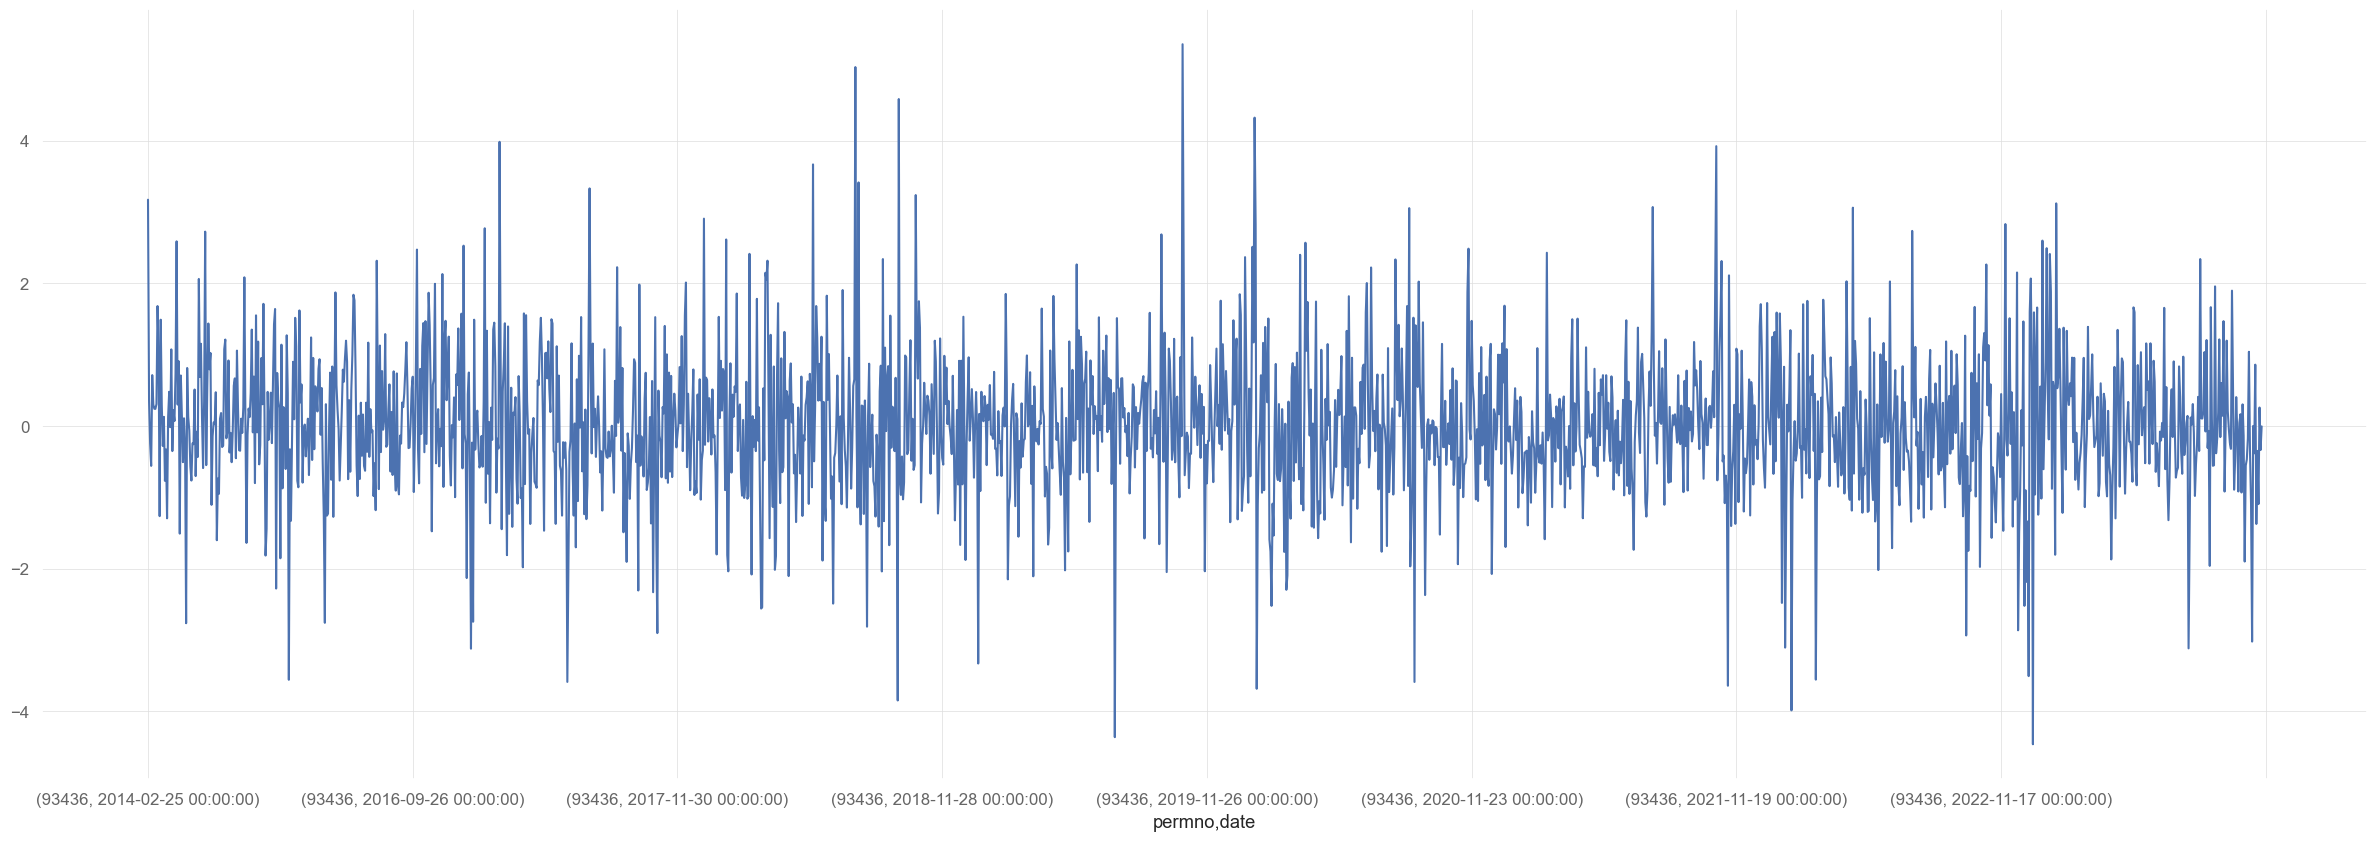

\

In [1359]:
tsla['s_score'].plot(figsize=(30, 10))

In [1371]:
# Signals
mom_buy = (betas_ret['s_score'] < -0.5)
# cumsum_buy = (betas_ret['CUSUM+'] > h)
buy_crossover = (betas_ret['ema_126'] > betas_ret['ema_252'])
rsi_buy = (betas_ret['rsi_5'] < 30)
volume_buy = (betas_ret['Volume'] > betas_ret['Volume'].rolling(window=60).mean())

/

In [1372]:
def select_top(df, top=50):
    filtered_df = df[df['signal'].abs() == 1]
    return filtered_df.nlargest(top, 'inv_vol')

-

In [1373]:
betas_ret['signal'] = np.where(mom_buy & rsi_buy & buy_crossover & volume_buy, 1, 0)
betas_ret['signal'] = np.where(mom_buy, 1, 0)
# betas_ret['signal'] = np.where(cumsum_buy, 1, 0)
betas_ret['vol'] = betas_ret.groupby('permno')['RET_01'].rolling(21).std().reset_index(level=0, drop=True)
betas_ret['inv_vol'] = 1 / betas_ret['vol']
top_betas_ret = betas_ret.groupby('date').apply(select_top).reset_index(level=0, drop=True)

|

In [1374]:
top_betas_ret['adj_weight'] = top_betas_ret['signal'] * top_betas_ret['inv_vol']
top_betas_ret['abs_adj_weight'] = top_betas_ret['adj_weight'].abs()
combined_weights = top_betas_ret.groupby('date')['abs_adj_weight'].sum()
top_betas_ret['normalized_weight'] = top_betas_ret['adj_weight'].div(combined_weights, axis=0)

In [1375]:
top_betas_ret['RET_01_shift'] = top_betas_ret.groupby('permno')['RET_01'].shift(-1)
trend_ret = (top_betas_ret['RET_01_shift'] * top_betas_ret['normalized_weight']).groupby('date').sum()

/

[*********************100%%**********************]  1 of 1 completed


-                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2005-07-05   2005-07-05
End Period                 2023-11-10   2023-11-10
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          268.62%      -100.0%
CAGR﹪                     5.03%        -100.0%

Sharpe                     0.46         -29.23
Prob. Sharpe Ratio         97.56%       0.0%
Smart Sharpe               0.19         -12.33
Sortino                    0.65         -13.95
Smart Sortino              0.27         -5.88
Sortino/√2                 0.46         -9.86
Smart Sortino/√2           0.19         -4.16
Omega                      0.0          0.0

Max Drawdown               -56.47%      -100.0%
Longest DD Days            1982         6702
Volatility (ann.)          19.59%       7.06%
R^2                        0.0          0.0
Information Ratio          -0.66        -0.66
Calmar   

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2005-07-06,2023-07-28,2023-11-10,6702,-100.0,-100.0


\

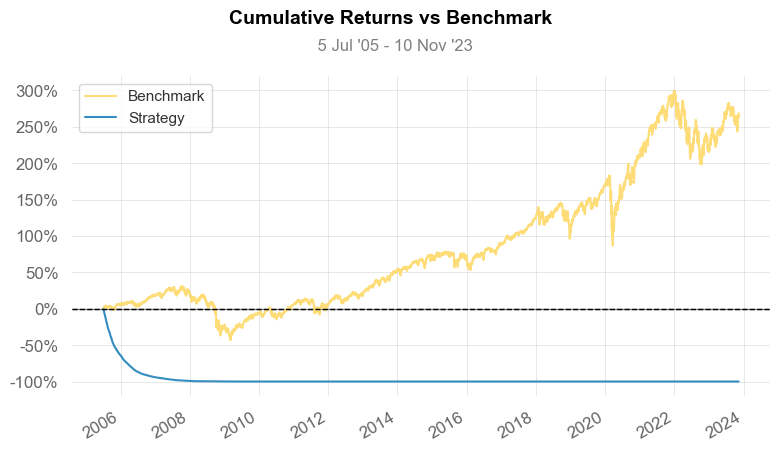

|

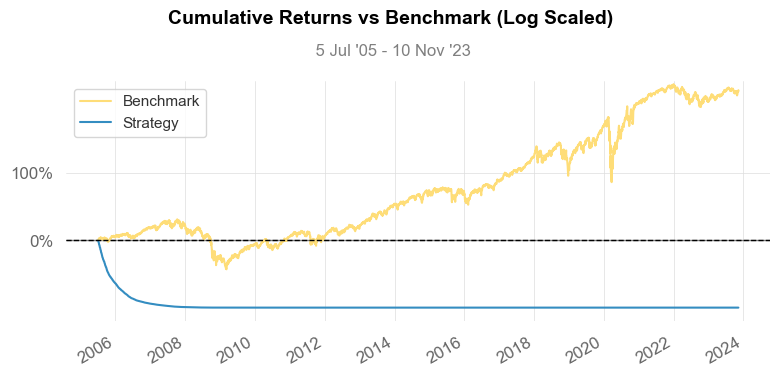

/

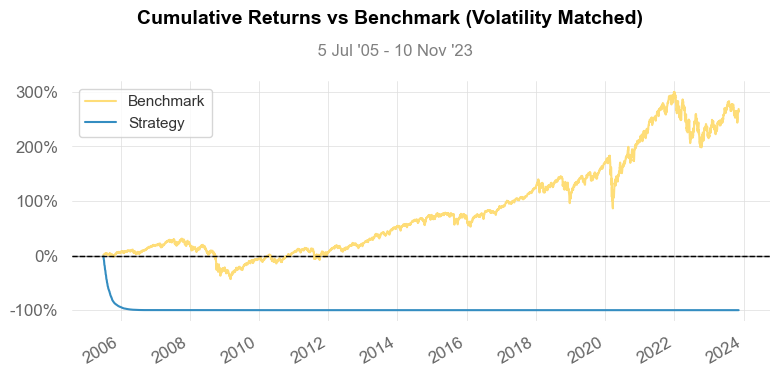

-

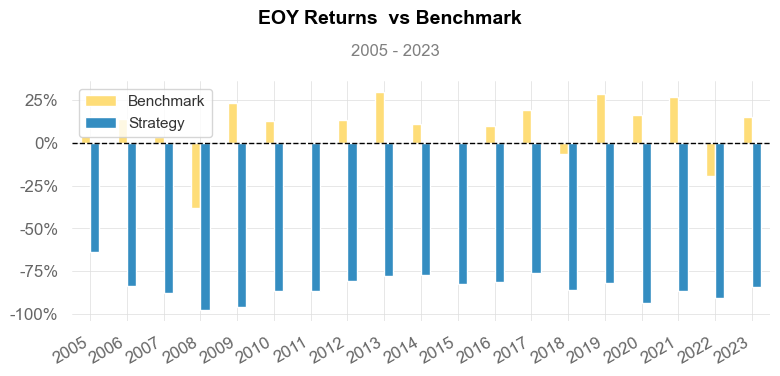

\

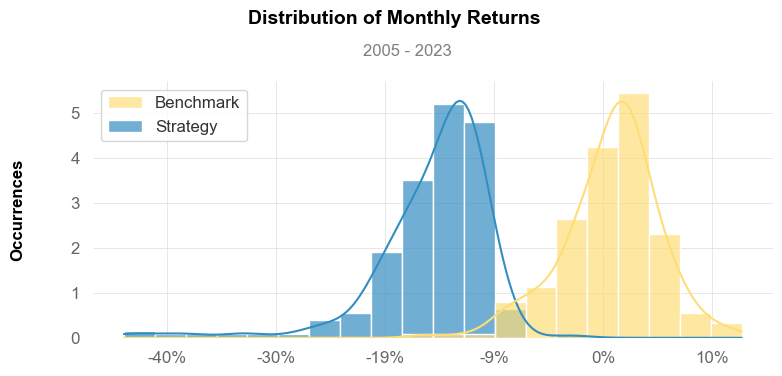

|

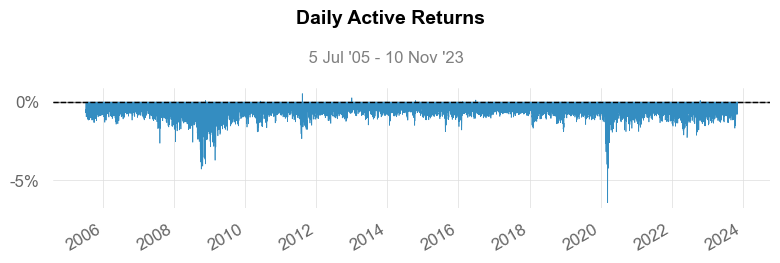

-

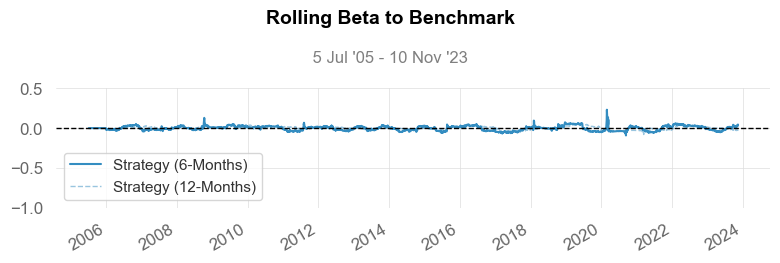

\

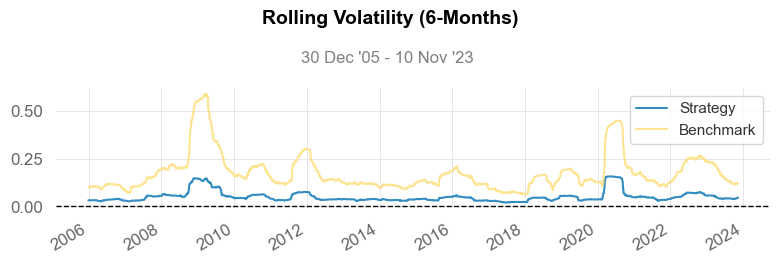

|

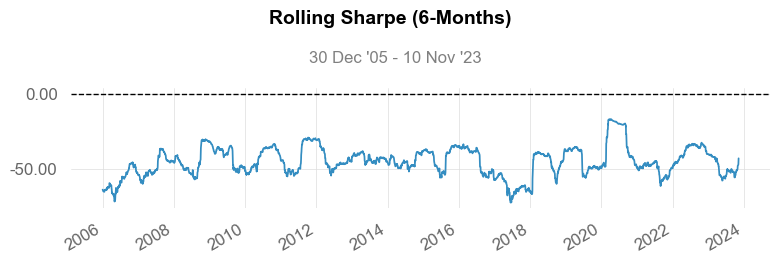

/

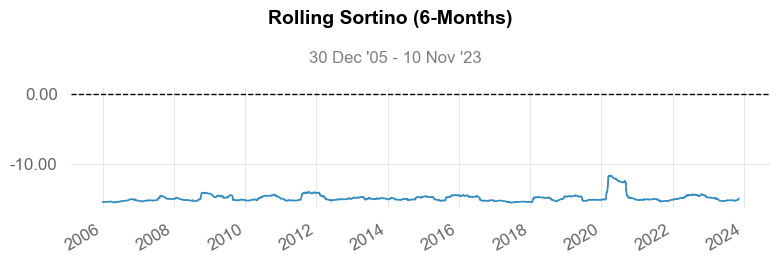

-

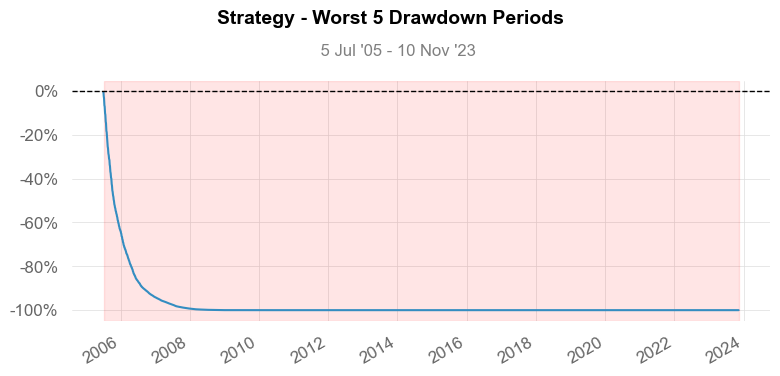

\

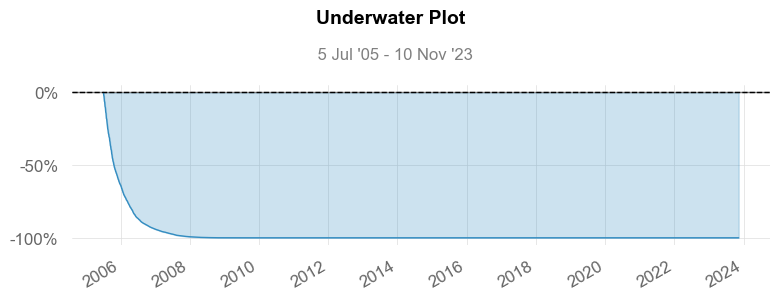

-

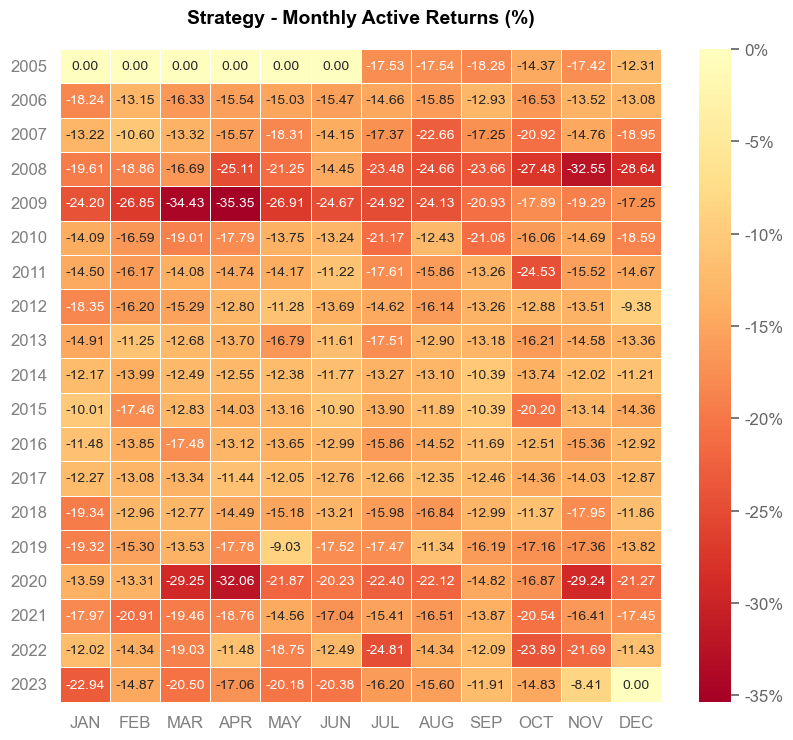

\

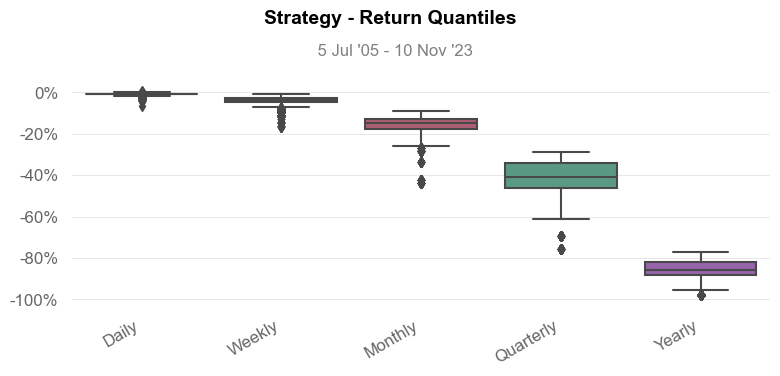

\

In [1376]:
qs.reports.full(trend_ret, 'SPY')

In [1281]:
comb_inv_ret = pd.merge(trend_ret.to_frame('trend_ret'), com_port, left_index=True, right_index=True, how='left')
comb_inv_ret = comb_inv_ret.merge(macro_buy_df, left_index=True, right_index=True, how='left')
col1, col2 = comb_inv_ret.columns[0], comb_inv_ret.columns[1]
comb_inv_ret['total_ret'] = comb_inv_ret.apply(calc_macro_port, args=(col1, col2), axis=1)
comb_inv_total = comb_inv_ret['total_ret']

In [ ]:
qs.reports.full(comb_inv_total, 'SPY')